In [137]:
# Library and module imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import openpyxl as xl
from datetime import datetime
import ast
from adjustText import adjust_text
from datasets import load_dataset
import seaborn as sns

In [ ]:
# load in Luke Barousse's jobs dataset as dataframe
dataset = load_dataset('lukebarousse/data_jobs')
jobs_data = dataset['train'].to_pandas()

Generating train split: 100%|██████████| 785741/785741 [00:03<00:00, 215368.74 examples/s]


In [ ]:
# Convert job_posted_date to datetime type, convert nested job skill list strings to lists, and output field info
jobs_data['job_posted_date'] = pd.to_datetime(jobs_data['job_posted_date'])
jobs_data['job_skills'] = jobs_data['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
jobs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785741 entries, 0 to 785740
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   job_title_short        785741 non-null  object        
 1   job_title              785740 non-null  object        
 2   job_location           784696 non-null  object        
 3   job_via                785733 non-null  object        
 4   job_schedule_type      773074 non-null  object        
 5   job_work_from_home     785741 non-null  bool          
 6   search_location        785741 non-null  object        
 7   job_posted_date        785741 non-null  datetime64[ns]
 8   job_no_degree_mention  785741 non-null  bool          
 9   job_health_insurance   785741 non-null  bool          
 10  job_country            785692 non-null  object        
 11  salary_rate            33067 non-null   object        
 12  salary_year_avg        22003 non-null   floa

In [ ]:
# QUESTIONS TO ANSWER
# What are the most demanded skills for the top 3 most popular data roles?
# How are in-demand skills trending for Data Analysts?
# How well do jobs and skills pay for Data Analysts?
# What is the most optimal skill to learn for Data Analysts? (High Demand
# AND High Paying)

In [15]:
# Creates chicago-based roles dataframe
chicago_roles_data = (
    jobs_data[(jobs_data['job_country'] == 'United States') & 
    (jobs_data['job_location'].str.lower().str.contains('chicago'))]
    )


In [ ]:
# Exploratory Analysis of Chicago Data Job Postings.
# What are the top data roles listed in Chicago?

chicago_roles_data['job_title_short'].value_counts()

job_title_short
Data Analyst                 2457
Data Scientist               1054
Data Engineer                 737
Senior Data Analyst           527
Senior Data Scientist         328
Business Analyst              269
Senior Data Engineer          228
Software Engineer              38
Machine Learning Engineer      15
Cloud Engineer                  8
Name: count, dtype: int64

In [42]:
# What are the top 5 companies hiring for the top 3 role types?

top_data_roles = ['Data Analyst', 'Data Scientist', 'Data Engineer']

top_chicago_roles = chicago_roles_data[chicago_roles_data['job_title_short'].isin(top_data_roles)].copy()
top_chicago_roles['company_name'].value_counts().head(10)

company_name
Insight Global                    62
Caterpillar                       47
Capital One                       38
AbbVie                            34
Northern Trust                    34
Northwestern University           33
BioSpace                          31
Rush University Medical Center    31
Epsilon                           30
Chicago Public Schools            28
Name: count, dtype: int64

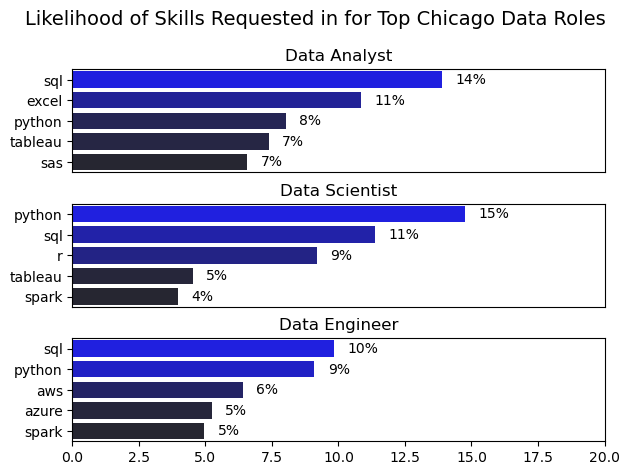

In [ ]:
# For the Top 3 Roles in Chicago, what are the top in-demand skills? 
top_chicago_skills = top_chicago_roles.explode('job_skills')

role_skill_counts = top_chicago_skills.groupby(['job_title_short', 'job_skills']).size().reset_index(name = 'count')
role_skill_counts['total_roleskill_mentions'] = role_skill_counts.groupby('job_title_short')['count'].transform('sum')

role_skill_counts['perc_mentions_byrole'] = (role_skill_counts['count'] / role_skill_counts['total_roleskill_mentions']) * 100

fig, ax = plt.subplots(3,1)

for i, value in enumerate(top_data_roles):
    plot_role_skills = role_skill_counts[role_skill_counts['job_title_short'] == value].sort_values('perc_mentions_byrole', ascending= False).head()
    sns.barplot(plot_role_skills, x = 'perc_mentions_byrole', y = 'job_skills', ax = ax[i], hue = 'count', palette= 'dark:blue')
    fig.suptitle('Likelihood of Skills Requested for Top Chicago Data Roles', fontsize=14)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(f'{value}')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0,20)
    for idx, v in enumerate(plot_role_skills['perc_mentions_byrole']):
        ax[i].text(v + 0.5, idx, f'{v:.0f}%', va='center')
    plt.tight_layout(h_pad=.8)
    # Only displays axis ticks for the last subplot
    if i != len(top_data_roles) - 1:
        ax[i].set_xticks([])

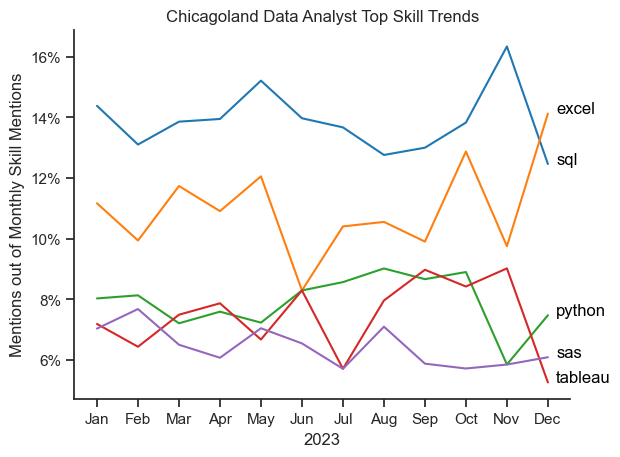

In [144]:
# How do Top Data Analyst Skills Trend Over the Year? 
chicago_analyst_subset = chicago_roles_data[chicago_roles_data['job_title_short'] == 'Data Analyst'].copy()
chicago_analyst_subset['posted_month'] = chicago_analyst_subset['job_posted_date'].dt.month

chicago_analyst_skills = chicago_analyst_subset.explode('job_skills')
chicago_analyst_monthly_skills = chicago_analyst_skills.pivot_table(index='posted_month', columns='job_skills',aggfunc='size', fill_value=0)

# Identify top skills across all months and sort columns accordingly
chicago_analyst_monthly_skills.loc['Total'] = chicago_analyst_monthly_skills.sum()
chicago_analyst_monthly_skills = chicago_analyst_monthly_skills[chicago_analyst_monthly_skills.loc['Total'].sort_values(ascending=False).index]
chicago_analyst_monthly_skills = chicago_analyst_monthly_skills.drop('Total')

# Calculate Monthly Skill Mentions compared to Monthly Total
chicago_analyst_monthly_skill_percents = chicago_analyst_monthly_skills.div(
    chicago_analyst_monthly_skills.sum(axis=1), axis=0
) * 100

# Convert Months to Month Names
chicago_analyst_monthly_skill_percents = chicago_analyst_monthly_skill_percents.reset_index()
chicago_analyst_monthly_skill_percents['month_name'] = chicago_analyst_monthly_skill_percents['posted_month'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
chicago_analyst_monthly_skill_percents = chicago_analyst_monthly_skill_percents.set_index('month_name')
chicago_analyst_monthly_skill_percents = chicago_analyst_monthly_skill_percents.drop(columns='posted_month')

# Visualize the Top 5 Skill Trends over Months
chicago_skills_plot = chicago_analyst_monthly_skill_percents.iloc[:,0:5]
sns.lineplot(chicago_skills_plot, legend=False, palette='tab10', dashes=False)

sns.set_theme(style='ticks')
sns.despine()

plt.title('Chicagoland Data Analyst Top Skill Trends')
plt.xlabel('2023')
plt.ylabel('Mentions out of Monthly Skill Mentions')
plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=0))

for i in range(5):
    plt.text(11.2, chicago_skills_plot.iloc[-1, i], chicago_skills_plot.columns[i], color='black')


359 out of 5661 jobs have salary data.


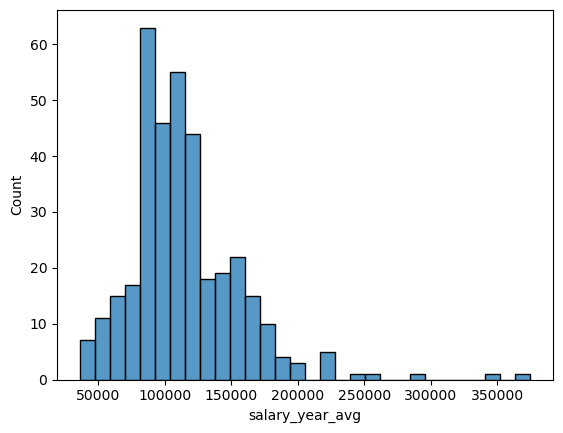

In [37]:
# How much Salary data from the Chicago cohort is usable and
# how is it distributed?
print(f'{chicago_roles_data['salary_year_avg'].count()} out of {len(chicago_roles_data['salary_year_avg'])} jobs have salary data.')
sns.histplot(chicago_roles_data, x = 'salary_year_avg')
plt.show()

In [ ]:
# How many of the top three Chicago roles have salary info?
print(f'{top_chicago_roles['salary_year_avg'].count()} out of {len(top_chicago_roles['salary_year_avg'])} jobs have salary data.')

top_chicago_roles_salaries = top_chicago_roles[top_chicago_roles['salary_year_avg'].isnull() == False]
top_chicago_roles_salaries['job_title_short'].value_counts()

256 out of 4248 jobs have salary data.


job_title_short
Data Analyst      130
Data Scientist     66
Data Engineer      60
Name: count, dtype: int64

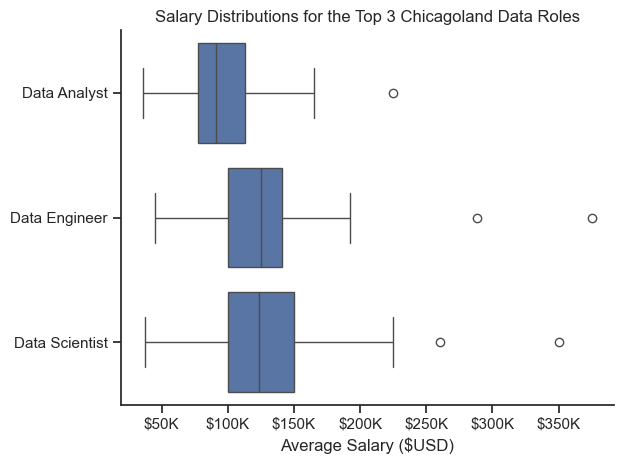

In [ ]:
# Plot the average salary distributions for the Top 3 Chicagoland Data Roles
sns.boxplot(top_chicago_roles_salaries, x='salary_year_avg', y='job_title_short')
sns.set_theme(style='ticks')
sns.despine()

plt.title('Salary Distributions for the Top 3 Chicagoland Data Roles')
plt.ylabel('')
plt.xlabel('Average Salary ($USD)')
ticks_x = plt.FuncFormatter(lambda x, pos: f'${int(x/1000)}K')
plt.gca().xaxis.set_major_formatter(ticks_x)

plt.tight_layout()
plt.show()


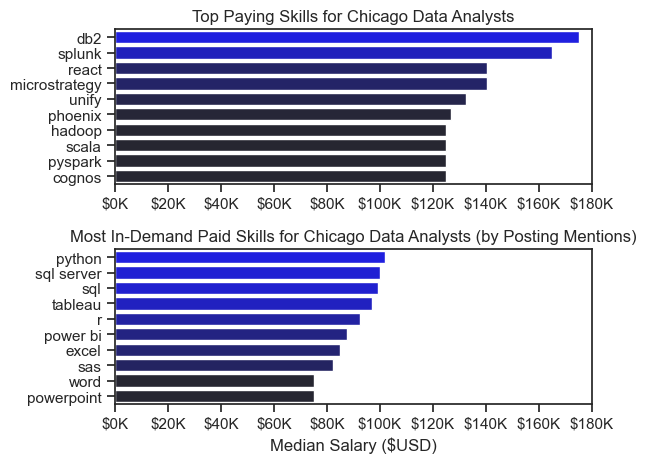

In [204]:
# Capture Data Analyst Skill Median Salaries and Counts by Skill Name
chicago_analyst_keymetrics = top_chicago_roles_salaries[top_chicago_roles_salaries['job_title_short'] == 'Data Analyst'].copy()
chicago_analyst_keymetrics = chicago_analyst_keymetrics.explode(column='job_skills')

# Create separate sorts for count and median top 10 skill ranking 
chicago_analyst_count_sort = chicago_analyst_keymetrics.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False).head(10).copy()
chicago_analyst_count_sort = chicago_analyst_count_sort.sort_values(by='median', ascending=False)

chicago_analyst_median_sort = chicago_analyst_keymetrics.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='median', ascending=False).head(10).copy()

# Create two plots showing most demanded Data Analyst Skills vs. Highest Paying

fig, ax = plt.subplots(2,1)

sns.barplot(chicago_analyst_median_sort, x='median', y='job_skills', hue='median', ax=ax[0], legend=False, palette="dark:blue")
ax[0].set_title('Top Paying Skills for Chicago Data Analysts')
ax[0].set_xlabel('')
ax[0].set_xlim(0,180000)
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))
ax[0].set_ylabel('')

sns.barplot(chicago_analyst_count_sort, x='median', y='job_skills', hue='median', ax=ax[1], legend=False, palette="dark:blue")
ax[1].set_title('Most In-Demand Paid Skills for Chicago Data Analysts (by Posting Mentions)')
ax[1].set_xlabel('Median Salary ($USD)')
ax[1].set_xlim(0,180000)
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))
ax[1].set_ylabel('')

plt.tight_layout()
sns.set_theme(style='ticks')
plt.show()

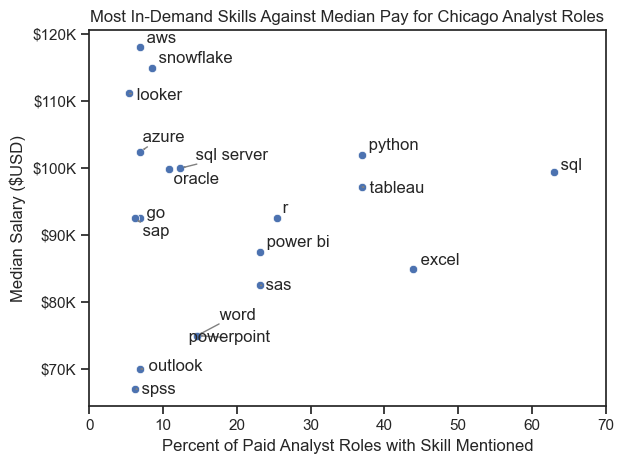

In [221]:
# Identify Top Paying Skills Vs. High Demand for Paid Chicago Analyst Positions

chicago_analyst_skills_bydemand = chicago_analyst_keymetrics.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

paid_chicago_analyst_count = len(top_chicago_roles_salaries[top_chicago_roles_salaries['job_title_short'] == 'Data Analyst'])

chicago_analyst_skills_bydemand['perc_of_paidjobs'] = (chicago_analyst_skills_bydemand['count'] / paid_chicago_analyst_count) * 100

chicago_analyst_topdemand_skills = chicago_analyst_skills_bydemand[chicago_analyst_skills_bydemand['perc_of_paidjobs'] > 5]

# Plot the relationship between the top demanded skills and their median pay

sns.scatterplot(chicago_analyst_topdemand_skills, x= 'perc_of_paidjobs', y= 'median', legend=False)
plt.title('Most In-Demand Skills Against Median Pay for Chicago Analyst Roles')
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${int(y/1000)}K'))
ax.set_xlabel('Percent of Paid Analyst Roles with Skill Mentioned')
ax.set_ylabel('Median Salary ($USD)')
ax.set_xlim(0, 70)

texts = []
for i, txt in enumerate(chicago_analyst_topdemand_skills.index):
    texts.append(plt.text(chicago_analyst_topdemand_skills['perc_of_paidjobs'].iloc[i], chicago_analyst_topdemand_skills['median'].iloc[i], " " + txt))

# Adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.tight_layout()
plt.show()